In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate

## read in adsorption data

In [3]:
R = 8.314 # universal gas constant [J/(mol-K)]

In [20]:
"""
    read_ads_data(mof, temperature)

mof (string): name of MOF
temperature (integer): in degree C
"""
def read_ads_data(mof, temperature):
    # reads adsorption isotherm data
    ads_data = pd.read_csv('data/{}_{}C.csv'.format(mof, temperature))

    # if the first row is zero RH, drop it.
    if ads_data['RH[%]'][0] == 0:
        ads_data = ads_data.drop(0)
        ads_data = ads_data.reset_index(drop=True)

    # convert humidity to P/P_0
    if ads_data['RH[%]'].iloc[-1] > 1: # truly a percent
        ads_data['P/P_0'] = ads_data['RH[%]'] / 100
    else: # RH ranges from 0 to 1
        ads_data['P/P_0'] = ads_data['RH[%]']

    # Gets rid of the Humidity column, now we're using P/P_0
    ads_data = ads_data.drop(columns=['RH[%]']) 
    
    # Polanyi adsorption potential for every P/P_0 in the data set
    ads_data["A [kJ/mol]"] = -R * (temperature + 273.15) * np.log(ads_data['P/P_0']) / 1000.0
   
    return ads_data

In [21]:
my_ads_data = read_ads_data("MOF_801", 25) # example
my_ads_data

,Water Uptake [kg kg-1],P/P_0,A [kJ/mol]
0,0.001,0.00114,16.798280
1,0.012,0.04805,7.524488
2,0.116,0.09840,5.747674
3,0.209,0.14874,4.723527
4,0.231,0.19680,4.029487
5,0.247,0.24714,3.464894
6,0.258,0.29748,3.005341
7,0.278,0.40046,2.268470
8,0.298,0.49886,1.723845
9,0.321,0.59954,1.268145


# Polyanyi adsorption theory
to predict water adsorption in a MOF at different T, P/P_0

In [31]:
"""
    characteristic_curve(ads_data)

returns interpolator of the data giving the characteristic curve,
which is the water uptake as a function (kg/kg) of Polynami adsorption potential A (kJ/mol).

"""
def characteristic_curve(ads_data): # does the above lines in a function 
    # sort rows by A values
    ads_data = ads_data.sort_values('A [kJ/mol]') 
    n_of_A = interpolate.PchipInterpolator(
        ads_data['A [kJ/mol]'], ads_data['Water Uptake [kg kg-1]']
    )
    return n_of_A

In [32]:
my_char_curve = characteristic_curve(my_ads_data)

In [56]:
"""
    predict_water_adsorption(T, P_over_P_0, n_of_A)

use Polyanyi potential to predict water adsorption in a MOF, 
given the temperature, P/P_0, and the characteristic curve.

to do so, we 
(i) calculate the Polyanyi potential
(ii) look up the water adsorption at that potential, on the char. curve.
"""
def predict_water_adsorption(T, P_over_P_0, n_of_A):
    # Calculate the Polanyi potential 
    A = -R * (T + 273.15) * np.log(P_over_P_0) / 1000.0
    # compute water adsorption at this A on the char. curve
    w = n_of_A(A).item() 
    return w # kg/kg

In [57]:
predict_water_adsorption(25.0, 0.29748, my_char_curve) # should be 0.258

0.258

## illustration with MOF-801

NameError: name 'n_of_P' is not defined

# explore MOF adsorption data
data sources:
* MOF-801 [link](oregonstate.edu)

In [69]:
MOFs = ['DUT_67', 'MOF_801', 'MOF_802', 'MOF_804', 'MOF_805', 'MOF_806', 'MOF_808', 'MOF_841', 'PIZOF_2', 'UiO_66']
data_temperatures = [20, 25, 20, 20, 20, 20, 20 ,20, 20, 20]

### plot adsorption isotherms

In [96]:
"""
plot the adsorption isotherm for a given MOF and temperature. 
"""
def viz_ads_isotherms(MOFs, data_temperatures):
    plt.figure()
    plt.title('water adsorption isotherms')
    plt.xlabel('relative humidity, P/P_0')
    plt.ylabel('water uptake [kg/kg]')
    for i in range(len(MOFs)):
        ads_data = read_ads_data(MOFs[i], data_temperatures[i]) # pull the file and calculate A values 
        plt.plot(
            ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'],
            label="{} {}$^\circ$C".format(MOFs[i], data_temperatures[i]),
            marker="o"
        )
    plt.legend(prop={'size': 8})

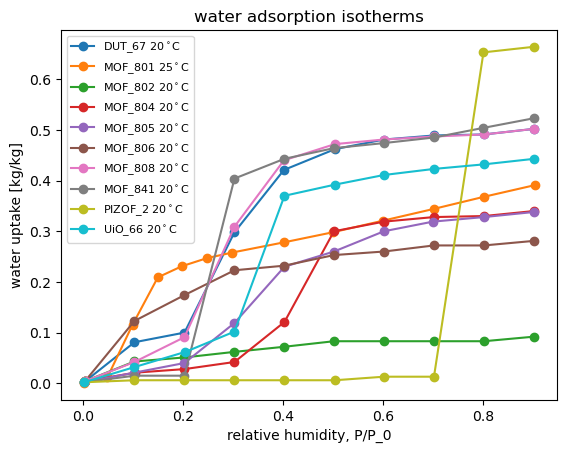

In [97]:
viz_ads_isotherms(MOFs, data_temperatures)

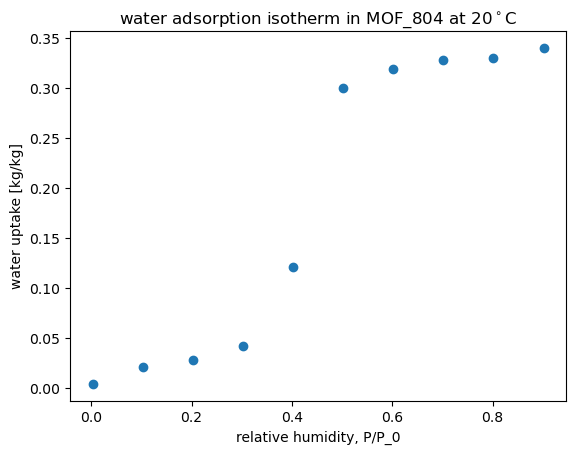

In [74]:
viz_ads_isotherm(MOFs[3], data_temperatures[3])

### plot characteristic curves

### compared Polyanyi-predicted and actual adsorption

# weather data

[source](https://weathersight.io/timeseries) for weather data for Phoenix from 2020-2021

In [53]:
df_weather = pd.read_csv('data/Phoenix_weather_edited_final.csv')
df_weather.head()

,Week,T_max_mean[C],T_min_mean[C],Max_dewp[C],Min_dewp[C]
0,1,19.8,4.6,-0.7,-3.6
1,2,20.0,4.7,-2.4,-5.7
2,3,23.2,8.6,3.9,-4.8
3,4,20.0,7.9,7.9,0.2
4,5,23.3,8.3,2.7,-3.8


find the saturated vapor pressure from temp and dewpt temp.
[source](https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf) for formula. 

In [54]:
"""
    calc_P_over_P_0(T, T_dew)
    
given a temperature and a dewpoint temperature, compute P/P_0 from the weather data.
T, T_dew units: deg. Celcius
"""
def calc_P_over_P_0(T, T_dew): 
    # calculate saturation pressure of water
    P_0 = 6.11 * 10 ** (7.5 * T / (237.3 + T))
    # calculate actual partial pressure of water
    P = 6.11 * 10 ** (7.5 * T_dew / (237.3 + T_dew)) 
    return P / P_0

In [55]:
calc_P_over_P_0(19.8, -3.6)

0.20270805178249135

In [12]:
 
def water_daily(week,kg_MOF,n_of_A): # find mass of water depending on weekly avg weather and mass MOF
    
    T_high, T_low, Dewp_high, Dewp_low = weekly_data(week) # extract weather data 

    
    P_over_P_0_high = pressure_calculations(T_high, Dewp_high) # calculate humidity during daily high
    
    P_over_P_0_low = pressure_calculations(T_low, Dewp_low) # calculate humidity during daily low
    
    A_low = -R * (T_low+273.15) * np.log(P_over_P_0_high) # calculate polanyi potential during daily high
    
    A_high = -R * (T_high+273.15) * np.log(P_over_P_0_low) # calculate polanyi potential during daily low
    
    high_water = calculate_water(T_high, P_over_P_0_high,n_of_A)  # calculate adsorption value during daily high
    
    low_water = (calculate_water(T_low, P_over_P_0_low,n_of_A)) # calculate adsorption value during daily low (should be higher than during daily high)
    
    water_rate = low_water - high_water # compare the high and low values to find amount of water kicked off by MOF over the course of a day per kg MOF 
    
    water_mass = water_rate * kg_MOF # multiply by kg MOF to find absolute mass of water produced per day under weekly avg conditions 
    
    #print('The mass of water collected by the MOF per day during week', week, 'is',round(water_mass,4),'[kg/day]')

    return water_mass, T_high, T_low

In [13]:
def Calculate_mass(mof, data_temp, week, kg_MOF): # using MOF data at MOF name mof and data temperature temp, calculate water from given week and mass MOF

    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 

    n_of_A = characteristic_curve(ads_data) # create characteristic curve 

    water_mass, T_high, T_low = water_daily(week,kg_MOF,n_of_A) # pull the water mass and high and low temps to see isotherms 

    #new_isotherm(T_high, n_of_A) # view high temp isotherm 
    #new_isotherm(T_low, n_of_A) # view low temp isotherm 
    #plt.title('Difference in isotherms by daily high and low avg temp')


    return water_mass # should be what is being optimized, changing kg_MOF for a given MOF and week  


## OPTIMIZATION ##
two optimization functions

one minimizes the total mass of MOF needed to produce a certain amount of water over a day (fixed output)

one maximizes the amount of water produced by a certain amount of MOF over a day (fixed input)

In [14]:
columns = ['MOF','Data Temp', 'Water Mass [kg/day]']


df = pd.DataFrame(columns=columns)
df['MOF'] = MOF
df['Data Temp'] = Data_temp
df

,MOF,Data Temp,Water Mass [kg/day]
0,DUT_67,20,NaN
1,MOF_801,25,NaN
2,MOF_802,20,NaN
3,MOF_804,20,NaN
4,MOF_805,20,NaN
5,MOF_806,20,NaN
6,MOF_808,20,NaN
7,MOF_841,20,NaN
8,PIZOF_2,20,NaN
9,UiO_66,20,NaN


In [15]:
def Optimize(week): # optimize the mass of MOF needed to produce a certain amount of water over a day (fixed output)

    water_mass_values = []

    kg_MOF = 0.1 # starting guess mass of each MOF 

    for i in range(len(df['MOF'])): # for each MOF in the dataframe find the amount of water produced over a day
        water_mass_MOF_i = Calculate_mass(df['MOF'][i], df['Data Temp'][i], week, kg_MOF)
        water_mass_values.append(water_mass_MOF_i)

    df['Water Mass [kg/day]'] = water_mass_values
    
    # m = 3.7 mass of water needed per day for a human [kg]

    #m = sum(water_mass_values) # find the difference between the water produced and the water needed
        
    return df


In [16]:
Optimize(1)

,MOF,Data Temp,Water Mass [kg/day]
0,DUT_67,20,0.028645
1,MOF_801,25,0.006579
2,MOF_802,20,0.002667
3,MOF_804,20,0.028182
4,MOF_805,20,0.021641
5,MOF_806,20,0.005427
6,MOF_808,20,0.028473
7,MOF_841,20,0.024750
8,PIZOF_2,20,0.000546
9,UiO_66,20,0.032872


## For viewing MOF graphs ##

In [17]:
# use water adsorption data and conditions to generate new isotherm curves by temp 
# given T, calculate all A and find ads point, then plot ads vs RH 

def new_isotherm(T,n_of_A):
    
    ads_values = []
    RH_values = []
    
    for i in range(100):
       
        A = -R * (T+273.15) * np.log((i+1)/100) # calculates polanyi potential for given T at given P/P_0

        ads = n_of_A(A).item() # finds ads value for given A value 

        RH_current = i+1

        ads_values.append(ads) # add these adsorption values to a list 

        RH_values.append(RH_current)
    
    df_new_isotherm = pd.DataFrame(ads_values, columns=['Adsorption value [kg H2O / kg MOF]']) # create dataframe with the adsorption data 

    df_new_isotherm.insert(0,'Relative Humidity',RH_values) # add RH to the dataframe 

    if df_new_isotherm['Relative Humidity'].iloc[-1] > 1:
        df_new_isotherm['P/P_0'] = df_new_isotherm['Relative Humidity'] / 100  # Converts the relative humidity to P/P_0 (from % to decimal)
    else:
        df_new_isotherm['P/P_0'] = df_new_isotherm['Relative Humidity']  # Converts the relative humidity to P/P_0 (changes name )

    df_new_isotherm["A"] = -R * (T+273.15) * np.log(df_new_isotherm['P/P_0']) # Calculates Polanyi adsorption potential for every point on the graph 

    # plots the new isotherm 
    #plt.scatter(df_new_isotherm['Relative Humidity'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]'], label = (T))
    #plt.xlabel('Relative Humidity [%]')
    #plt.ylabel('Adsorption value [kg H2O / kg MOF]')
    #plt.xlim(xmin=0)
    #plt.legend()

    n_of_RH_frac = interpolate.PchipInterpolator(df_new_isotherm['P/P_0'], df_new_isotherm['Adsorption value [kg H2O / kg MOF]']) # Finds the equation of the isotherm 
    
    #plt.plot(df_new_isotherm['Relative Humidity'], n_of_RH_frac(df_new_isotherm['Relative Humidity']), label = (T))
    #plt.legend()
    
    return df_new_isotherm, n_of_RH_frac

In [19]:
def view_characteristic_curve(mof, data_temp): # view the characteristic curve for a given MOF and temperature 
    
    ads_data = read_ads_data(mof, data_temp) # pull the file and calculate A values 
    
    n_of_A = characteristic_curve(ads_data) # create characteristic curve 
    
    
    plt.scatter(ads_data['A'], ads_data['Water Uptake [kg kg-1]'])
    plt.xlabel('A')
    plt.ylabel('Water Uptake [kg/kg]')
    plt.title('Characteristic curve for {} at {}C'.format(mof, data_temp))
    plt.scatter(ads_data['A'], n_of_A(ads_data['A']), label='Characteristic curve')

In [20]:
def view_mof (mof, data_temp): # view the isotherm and characteristic curve for a given MOF and temperature 
    
    view_isotherm(mof, data_temp)
    plt.show()
    view_characteristic_curve(mof, data_temp)
    plt.legend()

## Find Error of MOF 801 when using different input temperatures compared to data values ##

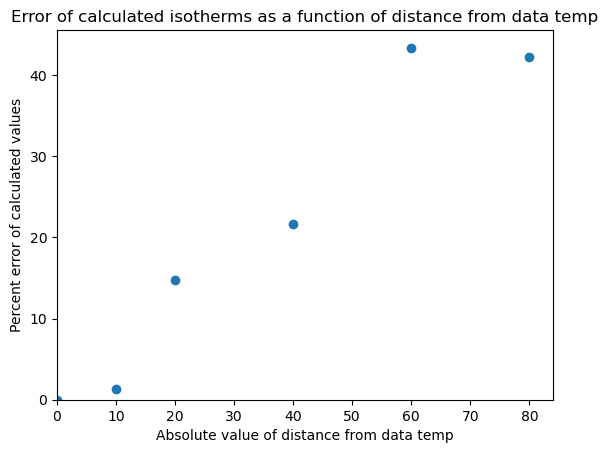

In [22]:
MOF = 'MOF_801'
ads_data = read_ads_data(MOF, 25) # pull the file and calculate A values

n_of_A = characteristic_curve(ads_data) # create characteristic curve

temps = [15, 25, 45, 65, 85, 105]
errs = [] 
dist = [] 

for i in range(len(temps)):
    
    df_temp, n_of_RH_temp = new_isotherm(temps[i],n_of_A)
    
    ads_temp = read_ads_data(MOF, temps[i])
    
    ads_temp.insert(1,'Calculated Adsorption',n_of_RH_temp(ads_temp['P/P_0']),True)
    
    ads_temp['Percent Error'] = abs(ads_temp['Water Uptake [kg kg-1]'] - ads_temp['Calculated Adsorption']) / ads_temp['Water Uptake [kg kg-1]'] * 100
    
    ads_temp.drop(index = [0, 1], inplace=True)
    
    err_temp = ads_temp['Percent Error'].mean()
    
    errs.append(err_temp)

    temp_dist = abs(25 - temps[i])

    dist.append(temp_dist)


plt.scatter(dist, errs) # plot error as a function of distance from data temp 
plt.xlabel('Absolute value of distance from data temp')
plt.ylabel('Percent error of calculated values')
plt.title('Error of calculated isotherms as a function of distance from data temp')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

# also look at error as a function of RH? 



In [28]:
def check_plot(temp):
    ads_data_25 = read_ads_data('MOF_801', 25)

    n_of_A = characteristic_curve(ads_data_25)

    df_temp, n_of_RH_temp = new_isotherm(temp,n_of_A)

    ads_temp = read_ads_data('MOF_801', temp)

    ads_temp.insert(1,'Calculated Adsorption',n_of_RH_temp(ads_temp['P/P_0']),True)

    plt.plot(ads_temp['P/P_0'], ads_temp['Water Uptake [kg kg-1]'], label = 'Experimental Data')

    plt.plot(ads_temp['P/P_0'], n_of_RH_temp(ads_temp['P/P_0']), label = 'Calculated Data')
    
    plt.xlabel('P/P_0')

    plt.ylabel('Water Uptake [kg/kg]')

    plt.legend()

    plt.title('Experimental vs. Calculated Isotherms for MOF_801 at {}C'.format(temp))



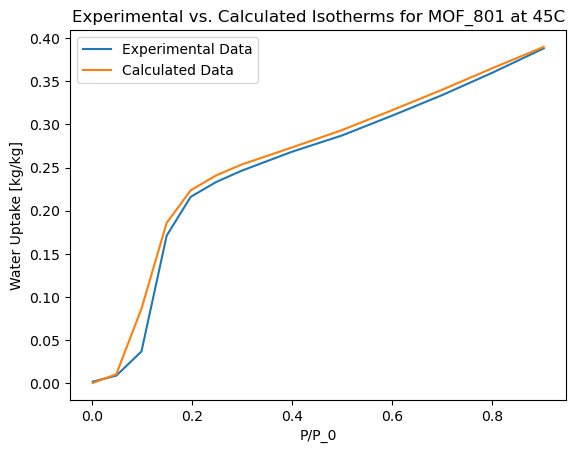

In [34]:
check_plot(45)

## NOTES ## 
 The 85 and 105 experimental data ends at lower RH values, and this only compares for values we possess data for. Thus, the calculated data is completely guessing (and also flattens out completely) and so the error would be much higher at those large RH values. <br> This shouldn't be a huge issue, as most if not all of the weather data shouldn't be higher than 50C or lower than -5C.

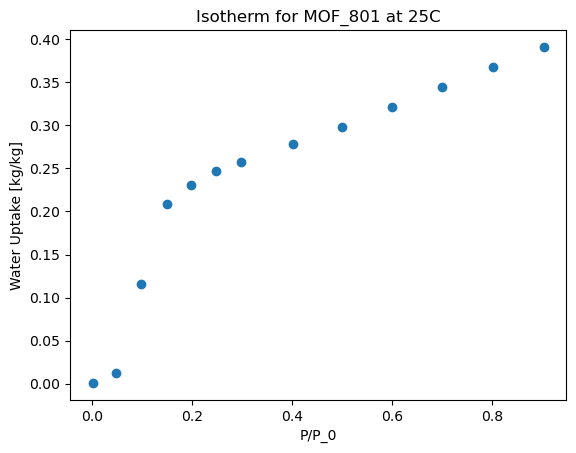

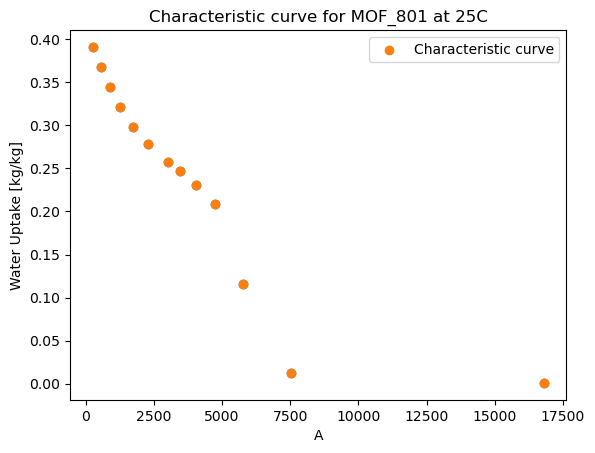

In [25]:
view_mof('MOF_801', 25)

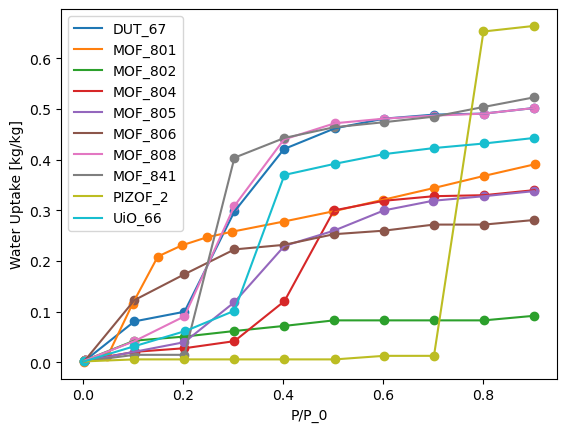

In [26]:
view_all()